In [79]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import torch.nn as nn

In [80]:
def create_sinusoids(batch_size, length, min_freq, max_freq):
    """
    Creates a batch of 1D sinusoids with random frequencies.
    
    Parameters:
    batch_size (int): Number of sinusoids in the batch.
    length (int): The length of each sinusoid.
    min_freq (float): The minimum frequency of the sinusoids.
    max_freq (float): The maximum frequency of the sinusoids.
    
    Returns:
    torch.Tensor: A tensor of shape (batch_size, length) containing the sinusoids.
    """
    # Generate random frequencies for each sinusoid in the batch
    frequencies = torch.rand(batch_size) * (max_freq - min_freq) + min_freq
    
    # Create a tensor for the x values
    x = torch.linspace(0, 2 * torch.pi, length).unsqueeze(0).repeat(batch_size, 1)
    
    # Create the sinusoids
    sinusoids = torch.sin(frequencies.unsqueeze(1) * x)
    
    return sinusoids

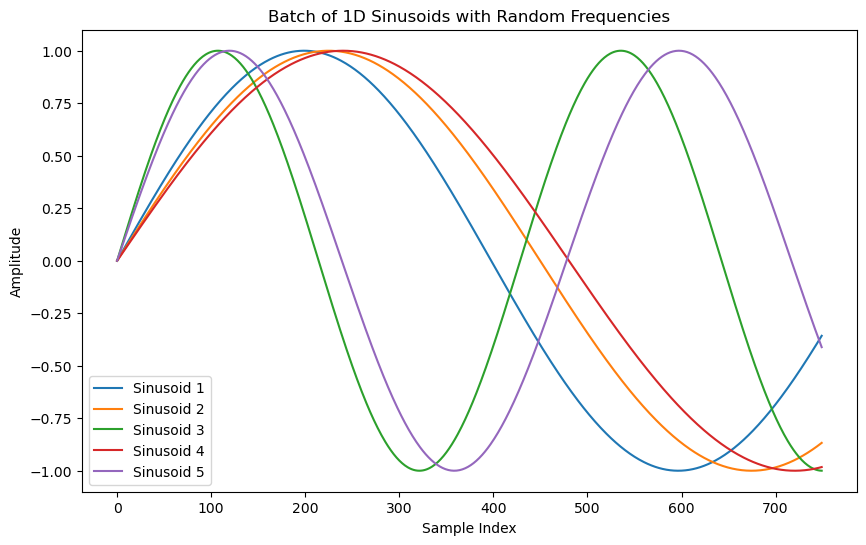

torch.Size([5, 750])


In [81]:
# Parameters
batch_size = 5
length = 750
min_freq = 0.5
max_freq = 2.0

# Generate the sinusoids
x = create_sinusoids(batch_size, length, min_freq, max_freq)

# Plot the sinusoids
plt.figure(figsize=(10, 6))
for i in range(batch_size):
    plt.plot(x[i].numpy(), label=f'Sinusoid {i+1}')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Batch of 1D Sinusoids with Random Frequencies')
plt.show()
print(x.shape)

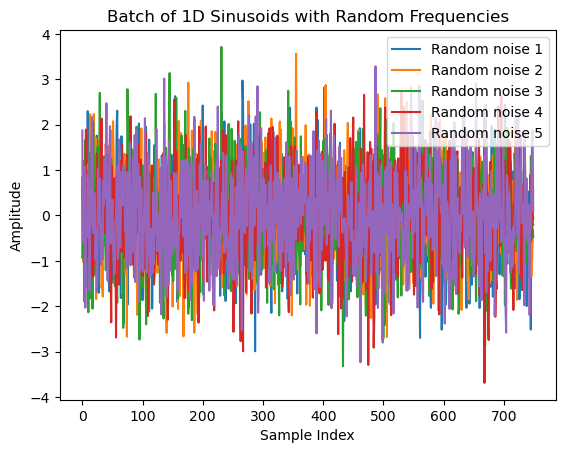

In [82]:
e = torch.randn_like(x)
for i in range(batch_size):
    plt.plot(e[i].numpy(), label=f'Random noise {i+1}')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Batch of 1D Sinusoids with Random Frequencies')
plt.show()

In [83]:
def get_beta_schedule(beta_schedule, *, beta_start, beta_end, num_diffusion_timesteps):
    def sigmoid(x):
        return 1 / (np.exp(-x) + 1)

    if beta_schedule == "quad":
        betas = (
            np.linspace(
                beta_start ** 0.5,
                beta_end ** 0.5,
                num_diffusion_timesteps,
                dtype=np.float64,
            )
            ** 2
        )
    elif beta_schedule == "linear":
        betas = np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif beta_schedule == "const":
        betas = beta_end * np.ones(num_diffusion_timesteps, dtype=np.float64)
    elif beta_schedule == "jsd":  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1.0 / np.linspace(
            num_diffusion_timesteps, 1, num_diffusion_timesteps, dtype=np.float64
        )
    elif beta_schedule == "sigmoid":
        betas = np.linspace(-6, 6, num_diffusion_timesteps)
        betas = sigmoid(betas) * (beta_end - beta_start) + beta_start
    else:
        raise NotImplementedError(beta_schedule)
    assert betas.shape == (num_diffusion_timesteps,)
    return betas

In [84]:
beta_schedule = 'linear'
beta_start = 0.0001
beta_end = 0.02
num_diffusion_timesteps = 1000

device = 'cpu'

betas = get_beta_schedule(
    beta_schedule=beta_schedule,
    beta_start=beta_start,
    beta_end=beta_end,
    num_diffusion_timesteps=num_diffusion_timesteps,
)
b = betas = torch.from_numpy(betas).float().to(device)
b.shape

torch.Size([1000])

In [85]:
num_timesteps = betas.shape[0]
n = x.size(0)
# antithetic sampling
t = torch.randint(
    low=0, high=num_timesteps, size=(n // 2 + 1,)
).to(device)
t = torch.cat([t, num_timesteps - t - 1], dim=0)[:n]
print(x.shape)

torch.Size([5, 750])


In [86]:
class IdentityModel(nn.Module):
    def __init__(self):
        super(IdentityModel, self).__init__()
        
    def forward(self, x, t):
        return x
model = IdentityModel()

In [87]:
def noise_estimation_loss(model,
                          x0: torch.Tensor,
                          t: torch.LongTensor,
                          e: torch.Tensor,
                          b: torch.Tensor, keepdim=False):

    a = (1-b).cumprod(dim=0).index_select(0, t).view(-1, 1,)
    print(t)
    x = x0 * a.sqrt() + e * (1.0 - a).sqrt()

    output = model(x, t.float())
    if keepdim:
        return (e - output).square().sum(dim=(1, 2, 3))
    else:
        print('here',(e - output).square().shape)
        return (e - output).square().sum(dim=(1)).mean(dim=0), x


loss_registry = {
    'simple': noise_estimation_loss,
}

In [88]:
loss, out = loss_registry['simple'](model, x, t, e, b)
out.shape

tensor([596, 529, 260, 403, 470])
here torch.Size([5, 750])


torch.Size([5, 750])

In [89]:
def plot_forward_process(noisified, t):
    fig, ax = plt.subplots(1, noisified.shape[0])
    fig.set_size_inches(40,2)

    for i, (noisified_i, t_i) in enumerate(zip(noisified, t)):
        ax[i].plot(noisified[:, 0], noisified[:, 1])
        ax[i].axis('off')
        ax[i].set_title(f'{t_i}', size=8)

tensor([  0,  52, 105, 157, 210, 262, 315, 368, 420, 473, 525, 578, 630, 683,
        736, 788, 841, 893, 946, 999])
here torch.Size([20, 750])


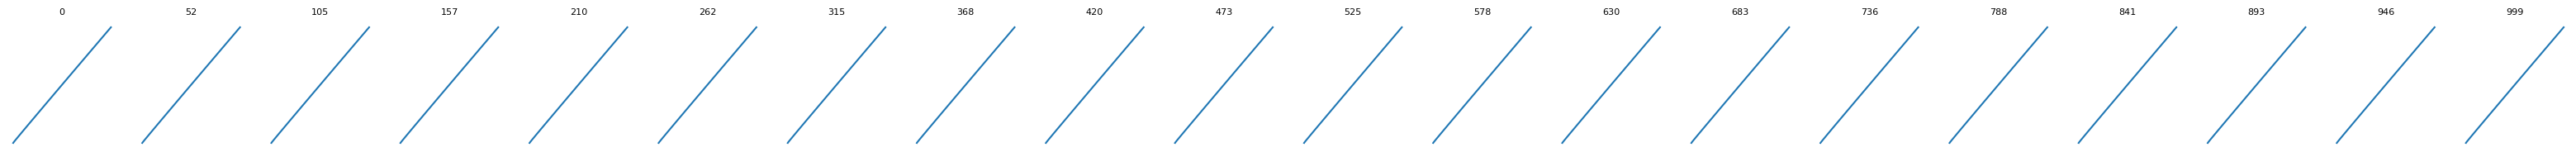

In [90]:
T = 1000
batch_size = 1
num_ims = T // 50


batch = create_sinusoids(batch_size, length, min_freq, max_freq)
e = torch.randn_like(batch)

batch_rep = batch.repeat(num_ims,*[1]*len(batch.shape[1:]))
t = torch.linspace(0,T-1,num_ims,dtype=torch.long)
loss, out = loss_registry['simple'](model, batch, t, e, b)
plot_forward_process(out, t)

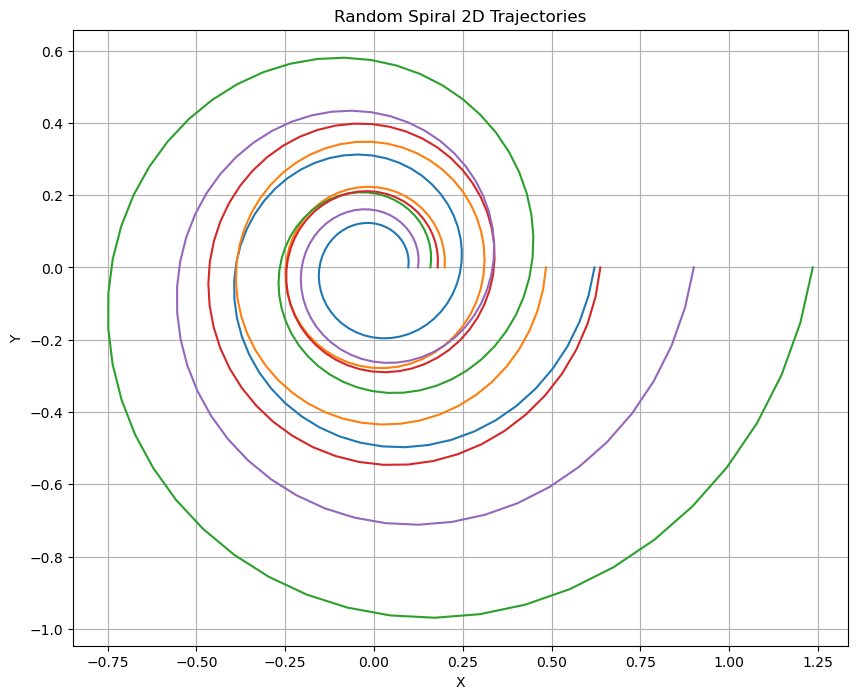

In [91]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def generate_random_spiral_trajectories(num_trajectories, trajectory_length, a_range=(0.05, 0.2), b_range=(0.05, 0.2)):
    """
    Generates spiral 2D trajectories with random a and b values.

    Parameters:
    num_trajectories (int): Number of trajectories to generate.
    trajectory_length (int): Length of each trajectory.
    a_range (tuple): Range of 'a' values for randomness.
    b_range (tuple): Range of 'b' values for randomness.

    Returns:
    torch.Tensor: A tensor of shape (num_trajectories, trajectory_length, 2) containing the trajectories.
    """
    # Initialize the trajectories tensor
    trajectories = torch.zeros(num_trajectories, trajectory_length, 2)
    
    # Generate spiral trajectories with random a and b values
    for i in range(num_trajectories):
        a = torch.FloatTensor(1).uniform_(*a_range).item()
        b = torch.FloatTensor(1).uniform_(*b_range).item()
        t = torch.linspace(0, 4 * np.pi, trajectory_length)
        r = a * torch.exp(b * t)
        x = r * torch.cos(t)
        y = r * torch.sin(t)
        trajectories[i, :, 0] = x
        trajectories[i, :, 1] = y
    
    return trajectories

def plot_trajectories(trajectories):
    """
    Plots the 2D trajectories.

    Parameters:
    trajectories (torch.Tensor): A tensor of shape (num_trajectories, trajectory_length, 2) containing the trajectories.
    """
    num_trajectories = trajectories.shape[0]
    
    plt.figure(figsize=(10, 8))
    
    for i in range(num_trajectories):
        trajectory = trajectories[i].numpy()
        plt.plot(trajectory[:, 0], trajectory[:, 1])
    
    plt.title('Random Spiral 2D Trajectories')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

# Example usage
num_trajectories = 5
trajectory_length = 100
a_range = (0.05, 0.2)
b_range = (0.05, 0.2)
trajectories = generate_random_spiral_trajectories(num_trajectories, trajectory_length, a_range, b_range)
plot_trajectories(trajectories)


In [92]:
def noise_estimation_loss(model,
                          x0: torch.Tensor,
                          t: torch.LongTensor,
                          e: torch.Tensor,
                          b: torch.Tensor, keepdim=False):

    a = (1-b).cumprod(dim=0).index_select(0, t).view(-1, 1,1)
    print(x0.shape, a.shape)
    x = x0 * a.sqrt() + e * (1.0 - a).sqrt()

    output = model(x, t.float())
    if keepdim:
        return (e - output).square().sum(dim=(1, 2, 3))
    else:
        print('here',(e - output).square().shape)
        return (e - output).square().sum(dim=(1)).mean(dim=0), x


loss_registry = {
    'simple': noise_estimation_loss,
}

torch.Size([20, 750, 2]) torch.Size([20, 1, 1])
here torch.Size([20, 750, 2])


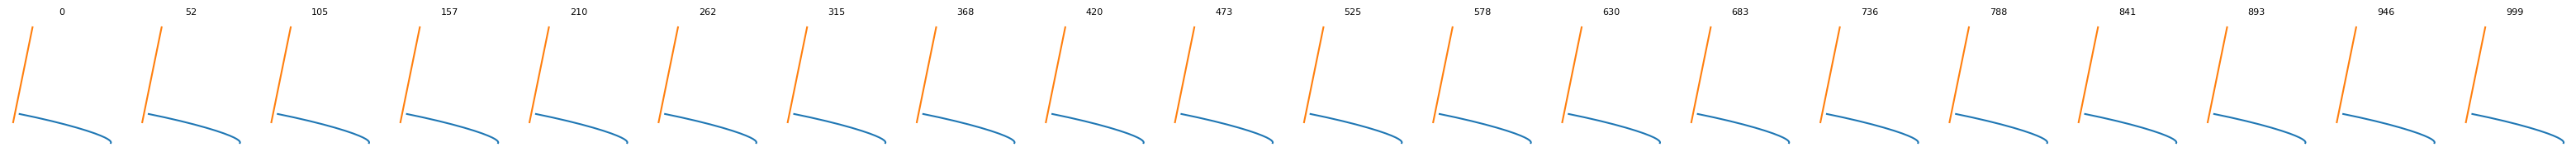

In [93]:
T = 1000
batch_size = 1
num_ims = T // 50

beta_schedule = 'linear'
beta_start = 0.0001
beta_end = 0.02
num_diffusion_timesteps = 1000

device = 'cpu'

betas = get_beta_schedule(
    beta_schedule=beta_schedule,
    beta_start=beta_start,
    beta_end=beta_end,
    num_diffusion_timesteps=num_diffusion_timesteps,
)
b = betas = torch.from_numpy(betas).float().to(device)
b.shape


batch = generate_random_spiral_trajectories(batch_size, 750, a_range, b_range)

e = torch.randn_like(batch)

batch_rep = batch.repeat(num_ims,*[1]*len(batch.shape[1:]))
t = torch.linspace(0,T-1,num_ims,dtype=torch.long)

loss, out = loss_registry['simple'](model, batch_rep, t, e, b)
plot_forward_process(out, t)